In [31]:
!pip install -q kaggle

# Make sure to upload kaggle.json from your computer here
from google.colab import files
files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
100% 811M/812M [00:09<00:00, 135MB/s]
100% 812M/812M [00:09<00:00, 93.9MB/s]


In [36]:
# Unzip the dataset
import zipfile
import os

with zipfile.ZipFile("/content/dogs-vs-cats.zip", "r") as zip_ref:
    zip_ref.extractall("/content")

# Unzip train.zip (this contains the images)
with zipfile.ZipFile("/content/train.zip", "r") as zip_ref:
    zip_ref.extractall("/content/dogs-vs-cats/train")

In [3]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy

In [4]:
# Define the image size (e.g., 128x128)
IMG_SIZE = 64

# Path to the folder containing the images
DATADIR = "/content/dogs-vs-cats/train/train/"

# Initialize arrays to hold data and labels
data = []
labels = []

# Load and process each image
for img in tqdm(os.listdir(DATADIR)):  # Iterate over each image in the folder
    try:
        img_array = cv2.imread(os.path.join(DATADIR, img))  # Read the image
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
        data.append(img_array)

        # Check if the image is of a cat or a dog based on its filename
        if "cat" in img:
            labels.append(0)  # Label 0 for 'cat'
        elif "dog" in img:
            labels.append(1)  # Label 1 for 'dog'
    except Exception as e:
        pass

# Convert data and labels to numpy arrays
data = np.array(data).astype('int')
labels = np.array(labels).reshape(-1, 1)  # Convert to column vector

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shapes of the data to verify
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

100%|██████████| 25000/25000 [00:48<00:00, 514.35it/s]


X_train shape: (20000, 64, 64, 3)
Y_train shape: (20000, 1)
X_test shape: (5000, 64, 64, 3)
Y_test shape: (5000, 1)


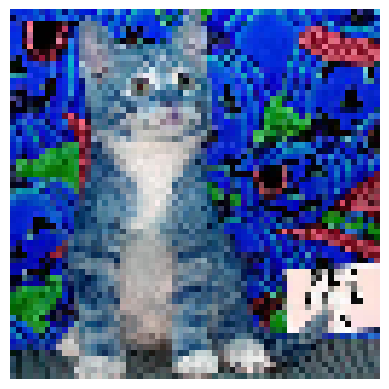

In [5]:
# Example of a picture
index = 27 # Choose the index of the image you want to display
plt.imshow(X_train[index])
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [6]:
# YOUR CODE STARTS HERE
m_train = X_train.shape[0]
m_test = X_test.shape[0]
num_px = X_train.shape[1]
# YOUR CODE ENDS HERE

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(X_train.shape))
print ("train_set_y shape: " + str(Y_train.shape))
print ("test_set_x shape: " + str(X_test.shape))
print ("test_set_y shape: " + str(Y_test.shape))

Number of training examples: m_train = 20000
Number of testing examples: m_test = 5000
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (20000, 64, 64, 3)
train_set_y shape: (20000, 1)
test_set_x shape: (5000, 64, 64, 3)
test_set_y shape: (5000, 1)


In [7]:
# Flatten the images (each image is 32x32x3, and needs to be flattened to a 3072-length vector)
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

In [8]:
Y_train = Y_train.T
Y_test = Y_test.T
train_set_x = X_train_flatten / 255.0
test_set_x = X_test_flatten / 255.0

In [9]:
print ("train_set_x_flatten shape: " + str(X_train_flatten.shape))
print ("train_set_y shape: " + str(Y_train.shape))
print ("test_set_x_flatten shape: " + str(X_test_flatten.shape))
print ("test_set_y shape: " + str(Y_test.shape))

train_set_x_flatten shape: (12288, 20000)
train_set_y shape: (1, 20000)
test_set_x_flatten shape: (12288, 5000)
test_set_y shape: (1, 5000)


In [10]:
def sigmoid(z):

    s = 1/(1+np.exp(-z))

    return s

In [11]:
def initialize_with_zeros(dim):

    w = np.zeros((dim,1))
    b = 0.0

    return w, b

In [12]:
def propagate(w, b, X, Y):

    m = X.shape[1]
    A = sigmoid(np.dot(w.T,X) + b)
    cost = (-1/m)*np.sum(np.dot(Y,np.log(A).T) + np.dot((np.subtract(1,Y)),np.log(np.subtract(1,A)).T))

    dw = (1/m)*np.dot(X,np.subtract(A,Y).T)
    db = (1/m)*np.sum(np.subtract(A,Y))

    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [13]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db

        if i % 100 == 0:
            costs.append(cost)

            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [14]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        Y_prediction[0, :] = (A[0, :] > 0.5).astype(int)

    return Y_prediction

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [16]:
logistic_regression_model = model(train_set_x, Y_train, test_set_x, Y_test, num_iterations=2000, learning_rate=0.03, print_cost=True)

Cost after iteration 0: 0.693147


<ipython-input-12-f1da0958d2c4>:5: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m)*np.sum(np.dot(Y,np.log(A).T) + np.dot((np.subtract(1,Y)),np.log(np.subtract(1,A)).T))


KeyboardInterrupt: 

y = 0, you predicted that it is a "0" picture.


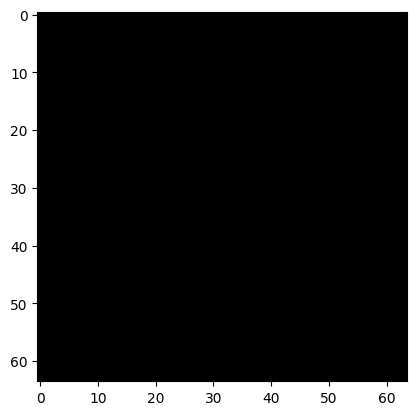

In [38]:
index = 27
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(Y_test[0,index]) + ", you predicted that it is a \"" + str(int(logistic_regression_model['Y_prediction_test'][0,index])) +  "\" picture.")